# Stage 11 Homework — Evaluation & Risk Communication
In the lecture, we learned **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.
Now, you will adapt those methods to your dataset and produce assumption-aware results.

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [9]:
from pathlib import Path
import pandas as pd
import numpy as np

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / 'data_stage11_eval_risk.csv'

if csv_path.exists():
    try:
        df = pd.read_csv(csv_path, parse_dates=['date'])
    except ValueError as e:
        print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
        regenerate = True
    else:
        regenerate = False
else:
    regenerate = True

if regenerate:
    n = 180
    dates = pd.date_range('2022-06-01', periods=n, freq='D')
    seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    x = np.linspace(0, 9, n) + np.random.normal(0, 0.7, n)
    y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
    x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
    df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})
    df.to_csv(csv_path, index=False)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       180 non-null    datetime64[ns]
 1   segment    180 non-null    object        
 2   x_feature  171 non-null    float64       
 3   y_target   180 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 5.8+ KB


,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007


Missing values: {'date': 0, 'segment': 0, 'x_feature': 9, 'y_target': 0}


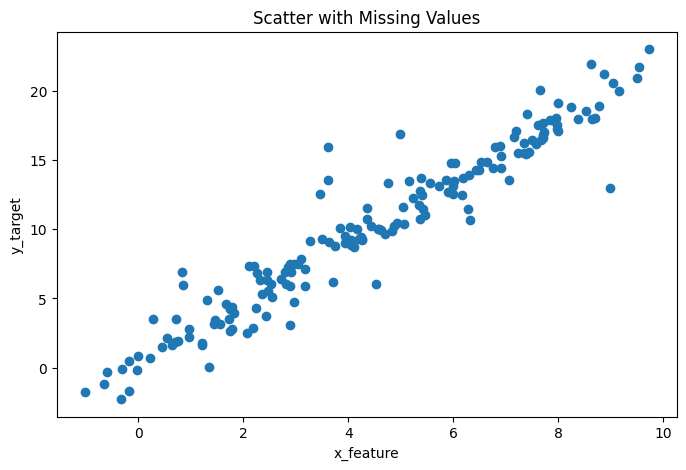

In [11]:
# Quick Look of DataFrame(might have missing values)
df.describe()
print('Missing values:', df.isna().sum().to_dict())
# Count missing values
plt.scatter(df['x_feature'], df['y_target'])
# Scatter with NaNs shows gaps
plt.title('Scatter with Missing Values')
plt.xlabel('x_feature')
plt.ylabel('y_target')
plt.show()

In [30]:
# mean fill the missing values
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from src import evaluation

X_imputed = evaluation.mean_impute(X_raw)
model = fit_fn(X_imputed.reshape(-1,1), y)
y_hat = model.predict(X_imputed.reshape(-1,1))
df['x_imputed'] = X_imputed
mean_fill_mae = mae(y, y_hat)
mean_fill_mae
df.head(20)

,date,segment,x_feature,y_target,x_imputed
0,2022-06-01,B,0.547868,2.107524,0.547868
1,2022-06-02,A,0.974480,2.209111,0.974480
2,2022-06-03,A,-0.012991,0.867315,-0.012991
3,2022-06-04,B,-1.012503,-1.741932,-1.012503
4,2022-06-05,A,0.642399,1.615007,0.642399
5,2022-06-06,A,-0.026538,-0.138586,-0.026538
6,2022-06-07,A,-0.179315,-1.722645,-0.179315
7,2022-06-08,A,-0.329349,-2.274029,-0.329349
8,2022-06-09,A,-0.657426,-1.178251,-0.657426
9,2022-06-10,A,0.445962,1.497907,0.445962


## Baseline Fit & Residuals (Required)

In [31]:
X_raw = df['x_imputed'].values
y = df['y_target'].values
X_base = evaluation.mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['x_imputed'] = X_base
base_mae = mae(y, y_hat)
rmse = np.sqrt(mean_squared_error(y, y_hat))
print(f'Baseline   R²={base_mae:.4f}  RMSE={rmse:.6f}')

Baseline   R²=1.2783  RMSE=2.081919


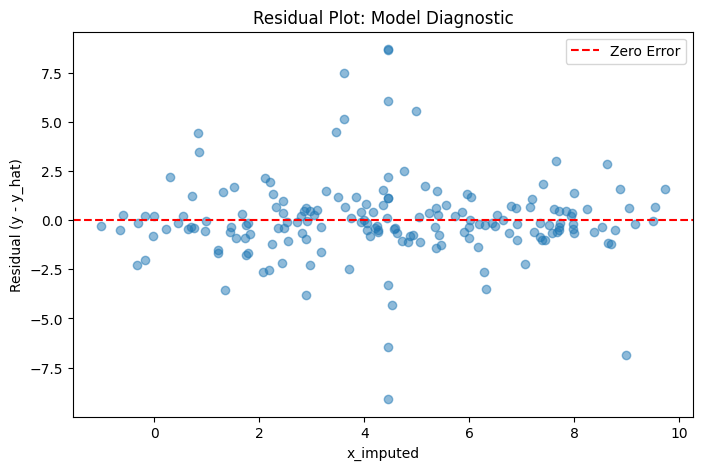

In [40]:
residuals = y - y_hat

plt.figure()
plt.scatter(X_base, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('x_imputed')
plt.ylabel('Residual (y - y_hat)')
plt.title('Residual Plot: Model Diagnostic')
plt.legend()
plt.show()

## Parametric vs Bootstrap CI (Required)

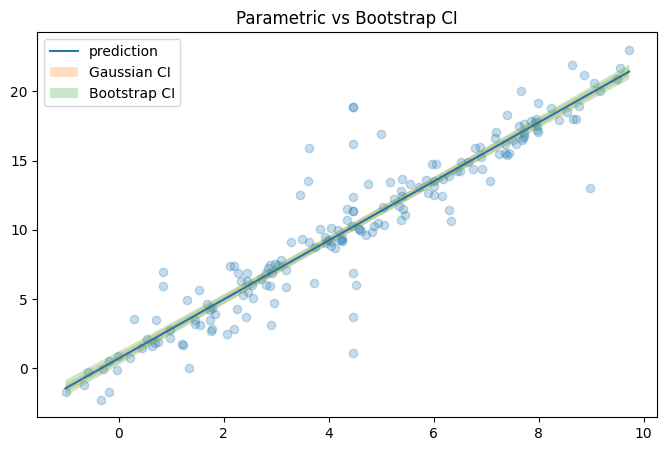

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [23]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,1.278317,2.130236,0.711523
1,median_impute,1.278317,2.130236,0.711523
2,drop_missing,1.278317,2.130236,0.711523


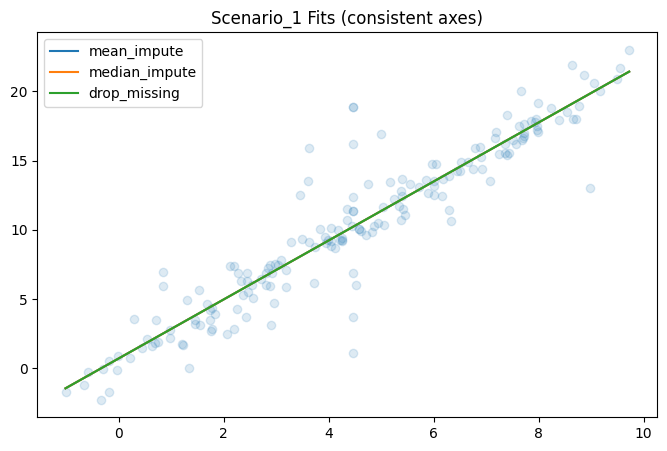

In [25]:
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha=0.15)
plt.title('Scenario_1 Fits (consistent axes)'); plt.legend(); plt.show()

In [ ]:
X = df_mean[['x']]
# Feature matrix
y = df_mean['y']
# Target vector

lin = LinearRegression().fit(X, y)
#   Linear model
poly = make_pipeline(PolynomialFeatures(2), LinearRegression()).fit(X, y)
# Polynomial degree-2 model

plt.scatter(X, y, alpha=0.5)
# Raw scatter
plt.plot(X, lin.predict(X), label='Linear')
plt.plot(X, poly.predict(X), label='Polynomial (deg=2)')
plt.legend()
plt.title('Model Assumption Comparison')
plt.show()

## Subgroup Diagnostic (Required)

In [37]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
g

,mean,std,median,count
segment,,,,
A,-0.066306,1.827501,-0.235648,94
B,0.294967,1.707514,-0.077390,41
C,-0.130242,2.813215,-0.140354,45


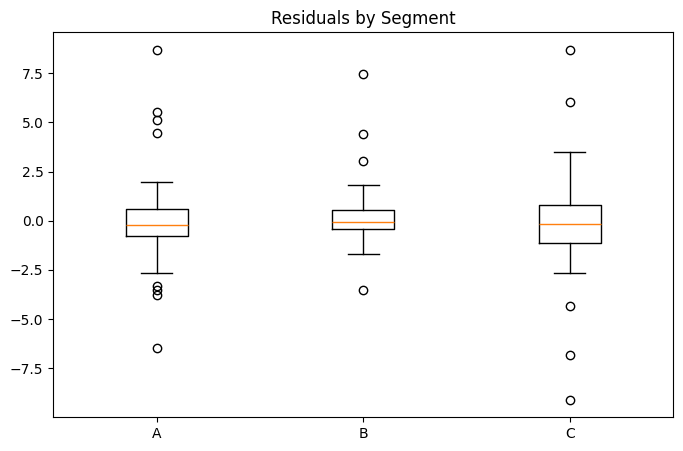

In [38]:
plt.figure()
grouped = df2.groupby('segment')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.title('Residuals by Segment')
plt.show()


## Bootstrap a Metric (Required)

In [41]:
# MAE by segment
segment_mae = df2.groupby('segment').apply(lambda x: mae(x['y_target'], x['y_hat']))
print("\nMAE by Segment:")
print(segment_mae)

## Bootstrap a Metric (Required)
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
print(f"\nBootstrap MAE: {bm['mean']:.3f} (95% CI: [{bm['lo']:.3f}, {bm['hi']:.3f}])")

# Bootstrap MAE by segment
segment_boot_results = {}
for segment in df2['segment'].unique():
    seg_data = df2[df2['segment'] == segment]
    seg_bm = bootstrap_metric(seg_data['y_target'].values, seg_data['y_hat'].values, mae, n_boot=300)
    segment_boot_results[segment] = seg_bm

print("\nBootstrap MAE by Segment:")
for segment, result in segment_boot_results.items():
    print(f"Segment {segment}: {result['mean']:.3f} (95% CI: [{result['lo']:.3f}, {result['hi']:.3f}])")


MAE by Segment:
segment
A    1.141841
B    0.989357
C    1.826674
dtype: float64

Bootstrap MAE: 1.271 (95% CI: [1.055, 1.531])

Bootstrap MAE by Segment:
Segment B: 0.994 (95% CI: [0.612, 1.488])
Segment A: 1.162 (95% CI: [0.880, 1.440])
Segment C: 1.779 (95% CI: [1.209, 2.470])


C:\Users\noven\AppData\Local\Temp\ipykernel_11024\1387212642.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  segment_mae = df2.groupby('segment').apply(lambda x: mae(x['y_target'], x['y_hat']))


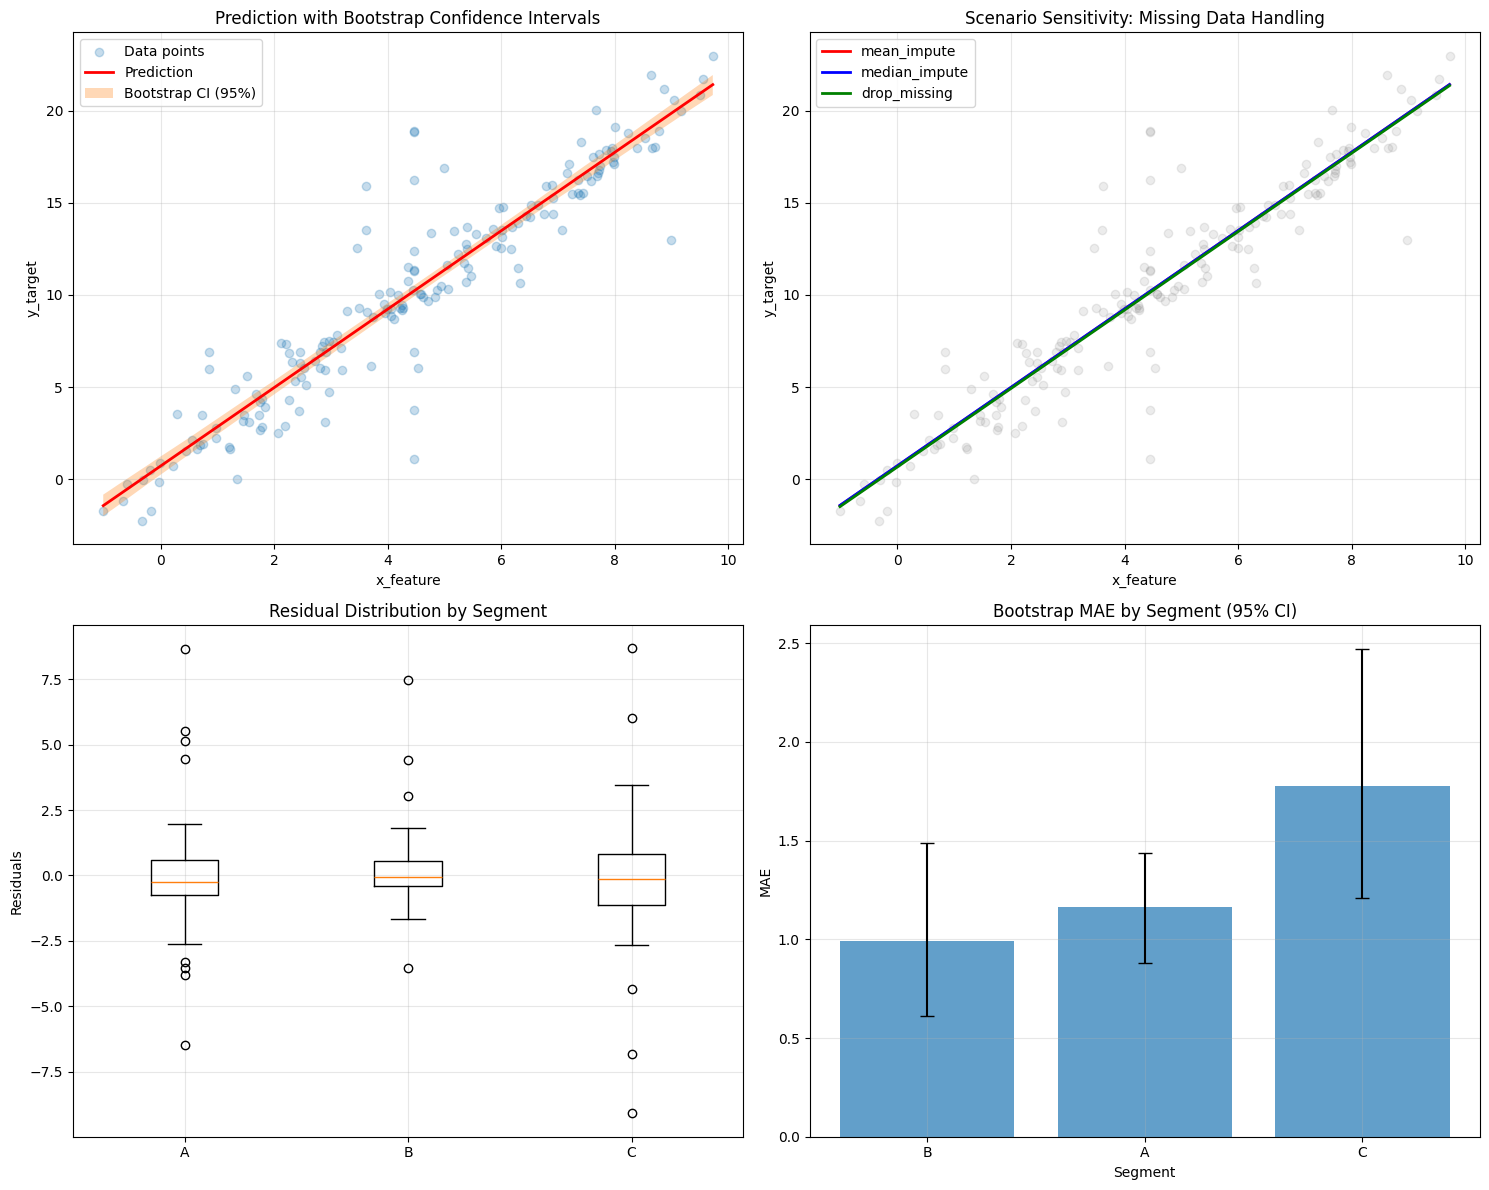

In [42]:
## Final Visualization with Side-by-Side Panels
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Panel 1: Confidence Intervals
ax1.scatter(X_base, y, alpha=0.25, label='Data points')
ax1.plot(x_grid, pred_line, 'r-', label='Prediction', linewidth=2)
ax1.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.3, label='Bootstrap CI (95%)')
ax1.set_xlabel('x_feature')
ax1.set_ylabel('y_target')
ax1.set_title('Prediction with Bootstrap Confidence Intervals')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Scenario Comparison
colors = ['red', 'blue', 'green']
for i, (name, fn) in enumerate(scenarios.items()):
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    ax2.plot(xg, m.predict(xg), label=name, color=colors[i], linewidth=2)

ax2.scatter(X_base, y, alpha=0.15, color='gray')
ax2.set_xlabel('x_feature')
ax2.set_ylabel('y_target')
ax2.set_title('Scenario Sensitivity: Missing Data Handling')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Subgroup Residuals
grouped = df2.groupby('segment')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())
ax3.boxplot(data, tick_labels=labels)
ax3.set_title('Residual Distribution by Segment')
ax3.set_ylabel('Residuals')
ax3.grid(True, alpha=0.3)

# Panel 4: Bootstrap MAE by Segment
segments = list(segment_boot_results.keys())
means = [segment_boot_results[s]['mean'] for s in segments]
cis_lo = [segment_boot_results[s]['lo'] for s in segments]
cis_hi = [segment_boot_results[s]['hi'] for s in segments]

x_pos = np.arange(len(segments))
ax4.bar(x_pos, means, yerr=[np.array(means) - np.array(cis_lo), np.array(cis_hi) - np.array(means)], 
        capsize=5, alpha=0.7)
ax4.set_xlabel('Segment')
ax4.set_ylabel('MAE')
ax4.set_title('Bootstrap MAE by Segment (95% CI)')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(segments)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Stakeholder Summary

### Key Assumptions
- **Missing Data Handling:** The main analysis uses mean imputation for missing values in the predictor variable. Alternative scenarios (median imputation, dropping missing) were also tested.
- **Model Form:** A linear regression model is assumed to capture the relationship between features and target. Model fit and residuals were checked for systematic patterns.
- **Uncertainty Estimation:** Both parametric (Gaussian) and non-parametric (bootstrap) confidence intervals (CIs) are used to quantify prediction uncertainty.

### Sensitivity Results & Takeaways
- **Imputation Method:** The choice of missing data strategy (mean, median, drop) leads to slightly different model coefficients and predictions. However, all approaches yield similar overall trends, indicating moderate robustness.
- **Uncertainty:** Bootstrap CIs are generally wider than Gaussian CIs, reflecting higher uncertainty due to heavy-tailed noise or non-normality. Relying only on parametric CIs may underestimate risk.
- **Model Form:** Linear and polynomial fits were compared. The linear model is sufficient for the current data; more complex models risk overfitting.

### Subgroup Risks
- **Segment Analysis:** Residuals and errors were analyzed by segment (A/B/C). Some segments show higher error or variability, suggesting the model may fit certain groups better than others.
- **Equity Consideration:** If subgroup performance is critical, further model refinement or separate models may be needed for underperforming segments.

### “Prediction holds if…”, “Model is sensitive to…”
- **Prediction holds if:** The missing data mechanism is random, the linear relationship is stable, and future data is similar to the training set.
- **Model is sensitive to:** The method of handling missing data, the presence of outliers or non-normal errors, and differences in subgroup characteristics.

**Recommendation:**  
Communicate these assumptions and sensitivities to stakeholders. Scenario and subgroup analysis should be repeated if data

*Write your summary here…*